This project aims to quantify the systemic and idiosyncratic risk characteristics of selected AI ETFs against broad market indices (S&P 500, NASDAQ) and to explore machine learning models for short-term return and volatility forecasting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
tickers = ["AIQ", "ARKQ", "WTAI", "IRBO", "ARTY", "ACWI", "^GSPC", "^IXIC"]
#AIQ: Global X Artificial Intelligence & Technology ETF
#ARKQ: ARK Autonomous Technology & Robotics ETF
#WTAI WisdomTree Artificial Intelligence and Innov Fund
#ARTY: iShares Future AI & Tech ETF
#ACWI: iShares MSCI ACWI ETF
#^GSPC SP500
#^IXIC :Nasdaq Composite

ai_etfs = ["AIQ", "ARKQ", "WTAI", "ARTY"]
market_indices = ["^GSPC", "^IXIC"]
tickers = ai_etfs + market_indices


df = yf.download(tickers, start='2019-01-01', end= '2025-03-31')['Close']
df = df.rename(columns={'^GSPC': 'GSPC', '^IXIC': 'IXIC'})

log_returns = np.log(df / df.shift(1))
simple_returns = df.pct_change()
volatility = log_returns.rolling(window=252).std() * np.sqrt(252)

dfs = {}
for ticker in df.columns:
    dfs[ticker] = pd.DataFrame({
        'Close': df[ticker],
        'LogReturn': log_returns[ticker],
        'SimpleReturn': simple_returns[ticker],
        'Volatility': volatility[ticker]
    })

AIQ = dfs['AIQ'].dropna()
ARKQ = dfs['ARKQ'].dropna()
WTAI = dfs['WTAI'].dropna()
ARTY = dfs['ARTY'].dropna()
SP500 = dfs['GSPC'].dropna()
Nasdaq = dfs['IXIC'].dropna()

dfs_string = {
    'AIQ': AIQ,
    'ARKQ': ARKQ,
    'WTAI': WTAI,
    'ARTY': ARTY,
    'GSPC': SP500,
    'IXIC': Nasdaq
}

combined_df = pd.concat(
    [df.assign(Fund=name) for name, df in dfs.items()],
    axis=0
).reset_index()

/tmp/ipython-input-31-209321233.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start='2019-01-01', end= '2025-03-31')['Close']
[*********************100%***********************]  6 of 6 completed


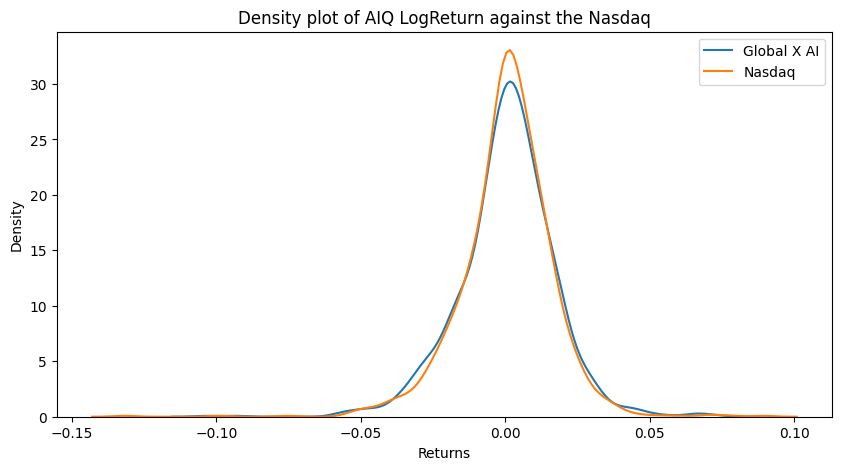

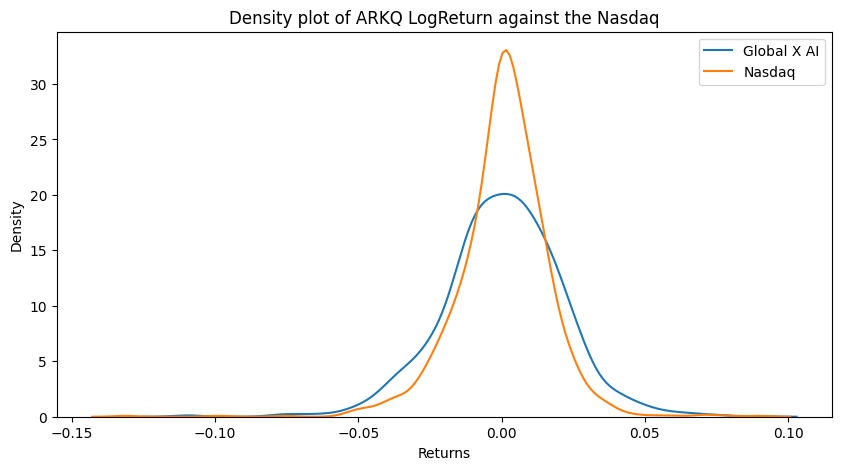

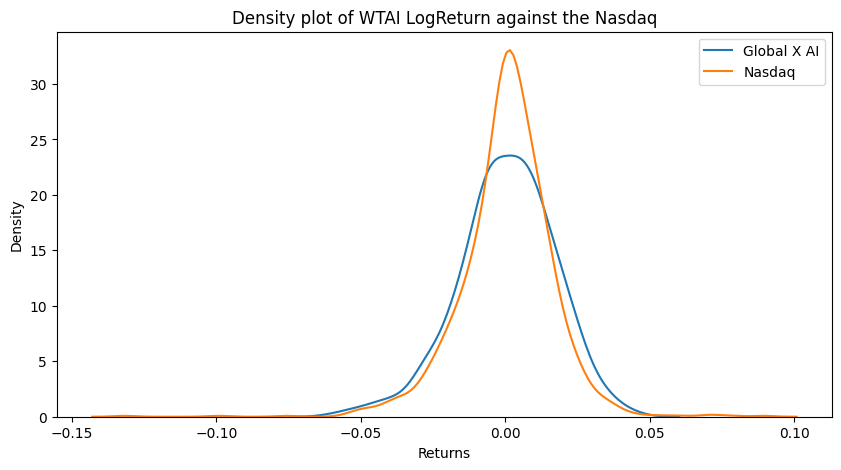

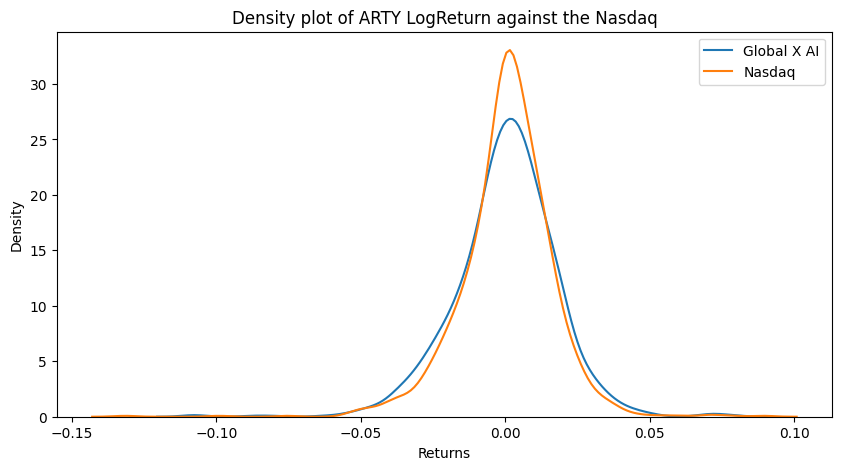

In [ ]:
#density plots of AI funds compared to Nasdaq and SP500
def density_plots(fund_name, data_point, sp500= None):
  fund = dfs_string[fund_name]
  plt.figure(figsize=(10, 5))
  sns.kdeplot(fund[data_point], label='Global X AI')
  sns.kdeplot(Nasdaq[data_point], label='Nasdaq')
  if sp500 == True:
    sns.kdeplot(SP500['SimpleReturn'], label='SP500')
  else:
    pass
  plt.xlabel('Returns')
  plt.legend()
  plt.title(f'Density plot of {fund_name} {data_point} against the Nasdaq')
  plt.show()


for fund in ['AIQ', 'ARKQ', 'WTAI', 'ARTY']:
    density_plots(fund, 'LogReturn', sp500=False)

Analysis of return distributions


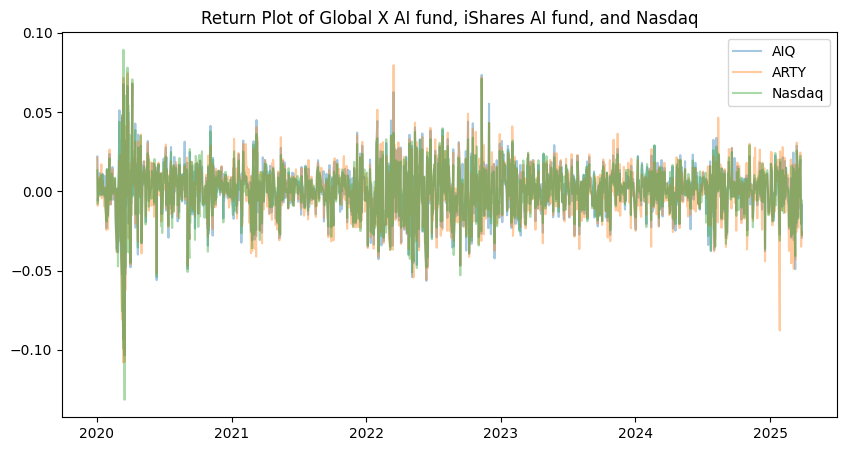

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(AIQ['LogReturn'], label='AIQ', alpha = 0.4)
plt.plot(ARTY['LogReturn'], label='ARTY', alpha = 0.4)
plt.plot(Nasdaq['LogReturn'], label='Nasdaq', alpha = 0.4)
plt.title('Return Plot of Global X AI fund, iShares AI fund, and Nasdaq')
plt.legend()
plt.show()

IQR of Volatility by Fund:
Fund
IXIC    0.127941
AIQ     0.119522
ARKQ    0.116534
GSPC    0.109698
ARTY    0.103905
WTAI    0.063138
Name: IQR, dtype: float64


/tmp/ipython-input-85-1110395870.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fund', y='Volatility', data=combined_df, palette='hls')


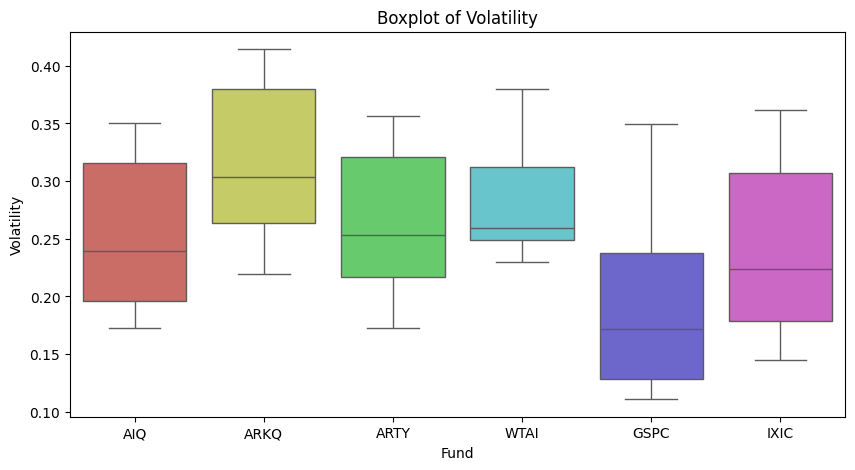

In [ ]:
# Boxplot of vol.

iqr_values = combined_df.groupby('Fund')['Volatility'].agg(
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75))
iqr_values['IQR'] = iqr_values['Q3'] - iqr_values['Q1']

print("IQR of Volatility by Fund:")
print(iqr_values['IQR'].sort_values(ascending=False))

# Plotting boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Fund', y='Volatility', data=combined_df, palette='hls')
plt.xlabel('Fund')
plt.ylabel('Volatility')
plt.title('Boxplot of Volatility')
plt.show()

The boxplot shows that there is no overarching trend in the spreads/IQR of volatility between AI funds as they each vary.

-WisdomTree AI fund has the lowest spread/IQR of all funds here, this is possibly if not probably due to it having the shortest time on the market. Second least spread in terms of volatility is iShares AI fund having an IQR of 0.103 with the largest spread being Nasdaq with an IQR of 0.128, or 250 basis points of volatility.

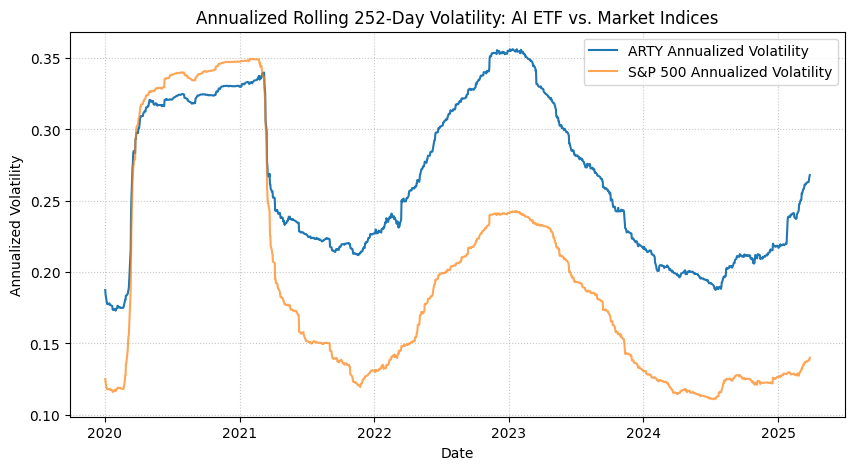

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(volatility['ARTY'], label='ARTY Annualized Volatility')
plt.plot(volatility['GSPC'], label='S&P 500 Annualized Volatility', alpha=0.7)
plt.title('Annualized Rolling 252-Day Volatility: AI ETF vs. Market Indices')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [ ]:
WTAI

,Close,LogReturn,SimpleReturn,Volatility
Date,,,,
2022-12-09,14.883030,-0.007581,-0.007553,0.373982
2022-12-12,15.151281,0.017863,0.018024,0.374509
2022-12-13,15.419536,0.017550,0.017705,0.374846
2022-12-14,15.359924,-0.003873,-0.003866,0.374436
2022-12-15,14.789639,-0.037835,-0.037128,0.375035
...,...,...,...,...
2025-03-24,20.799999,0.028528,0.028939,0.274602
2025-03-25,20.860001,0.002881,0.002885,0.274414
2025-03-26,20.270000,-0.028691,-0.028284,0.275869


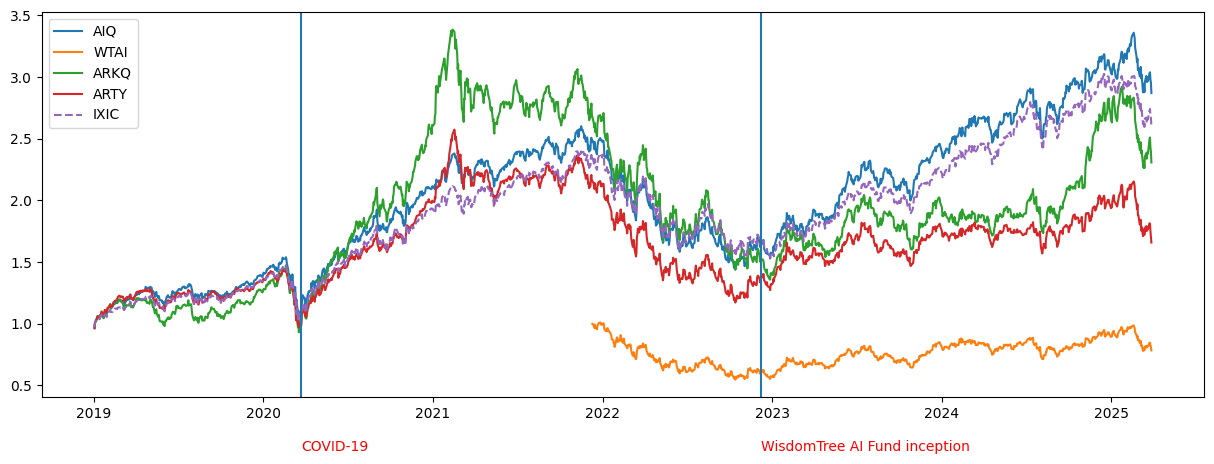

In [ ]:
cumprod = (1 + simple_returns).cumprod()
plt.figure(figsize=(15, 5))
plt.plot(cumprod['AIQ'], label='AIQ')
plt.plot(cumprod['WTAI'], label='WTAI')
plt.plot(cumprod['ARKQ'], label='ARKQ')
plt.plot(cumprod['ARTY'], label='ARTY')
#plt.plot(cumprod['GSPC'], label='GSPC')
plt.plot(cumprod['IXIC'], label='IXIC', ls = '--')
plt.axvline(pd.to_datetime("2022-12-09"))
plt.text(pd.to_datetime("2022-12-09"), y = 0, s='WisdomTree AI Fund inception', color='red', verticalalignment='center')
plt.axvline(pd.to_datetime("2020-03-23"))
plt.text(pd.to_datetime('2020-03-23'), y = 0, s='COVID-19', color='red', verticalalignment='center')
plt.legend()

In [ ]:
cumprod.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20',
               '2025-03-21', '2025-03-24', '2025-03-25', '2025-03-26',
               '2025-03-27', '2025-03-28'],
              dtype='datetime64[ns]', name='Date', length=1569, freq=None)

## Predicition

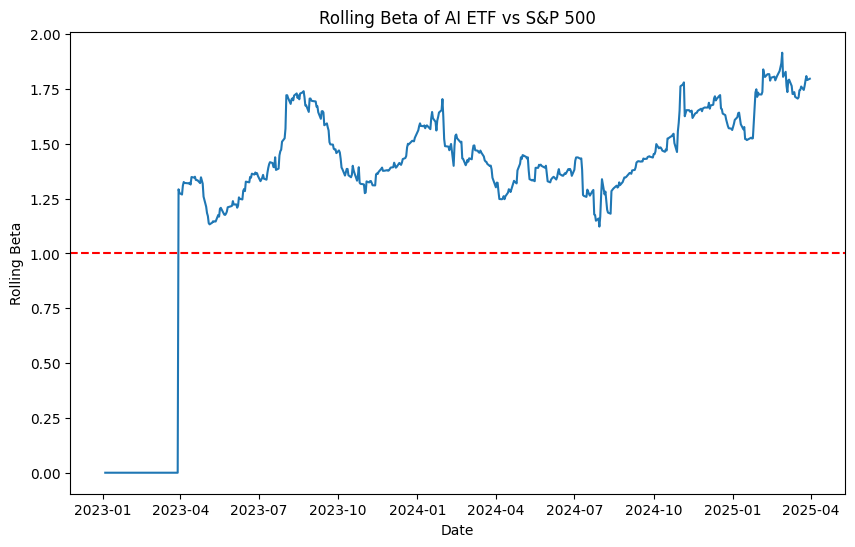

In [ ]:
def rolling_beta(asset_returns, market_returns, window):
    cov_matrix = asset_returns.rolling(window).cov(market_returns)
    market_var = market_returns.rolling(window).var()
    return cov_matrix / market_var

AI_rolling_beta = rolling_beta(AI_returns['ARTY'], SP500_returns['^GSPC'], 60).fillna(0)

plt.figure(figsize=(10, 6))
plt.plot(AI_rolling_beta)
plt.axhline(y=1, linestyle="--", color="r", label="Beta = 1")
plt.title('Rolling Beta of AI ETF vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Rolling Beta')
plt.show()

In [ ]:
# seems high. iShares AI fund's main holdings are Broadcom Inc, Super Micro Computer Inc, Nvidia corp
BroadcomInc = yf.download('AVGO', start_date)
BroadcomInc_ret = BroadcomInc['Close'].pct_change().dropna()

SuperMicroComputerInc = yf.download('SMCI', start_date)
SuperMicroComputerInc_ret = SuperMicroComputerInc['Close'].pct_change().dropna()

NvidiaCorp = yf.download('NVDA', start_date)
NvidiaCorp_ret = NvidiaCorp['Close'].pct_change().dropna()

print("Broadcom Inc Beta is: ", beta(BroadcomInc_ret['AVGO'], SP500_returns['^GSPC']))
print("Super Micro Computer Inc Beta is: ", beta(SuperMicroComputerInc_ret['SMCI'], SP500_returns['^GSPC']))
print("Nvidia Beta is: ", beta(NvidiaCorp_ret['NVDA'], SP500_returns['^GSPC']))

# these all have beta ~2 so high rolling beta of 1.7 makes sense for iShares AI ETF.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Beta via covariance 2.070925851833608     Beta via regression 2.0672343619016416
Broadcom Inc Beta is:  None
Beta via covariance 2.721564583403417     Beta via regression 2.71671330963621
Super Micro Computer Inc Beta is:  None
Beta via covariance 2.4533148943870984     Beta via regression 2.448941784058423
Nvidia Beta is:  None


In [ ]:
X = pd.DataFrame({
    "AI_Daily_Vol": AI_daily_vol['ARTY'],
    "AI_Rolling_Beta": AI_rolling_beta,
    "SP500_Returns": SP500_returns['^GSPC'],
    "SP500_Daily_Vol": SP500_daily_vol['^GSPC']
}).set_index(AI_daily_vol.index).fillna(0)

y = AI_returns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(X.tail(), y.head()) # tail bcos the rolling variables all have zeros at the start

            AI_Daily_Vol  AI_Rolling_Beta  SP500_Returns  SP500_Daily_Vol
Date                                                                     
2025-03-25      0.353604         1.764053       0.001574         0.159928
2025-03-26      0.359938         1.788304      -0.011157         0.161357
2025-03-27      0.362231         1.808901      -0.003307         0.160044
2025-03-28      0.365101         1.790744      -0.019737         0.163480
2025-03-31      0.367636         1.796783      -0.010995         0.164649 Ticker          ARTY
Date                
2023-01-04  0.027840
2023-01-05 -0.015354
2023-01-06  0.019884
2023-01-09  0.017656
2023-01-10  0.011074


MAE: 0.0069
MSE: 0.0001

Predicted Volatility: 0.0126
Real Volatility: 0.0140


<ipython-input-14-15c058ee1dfd>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


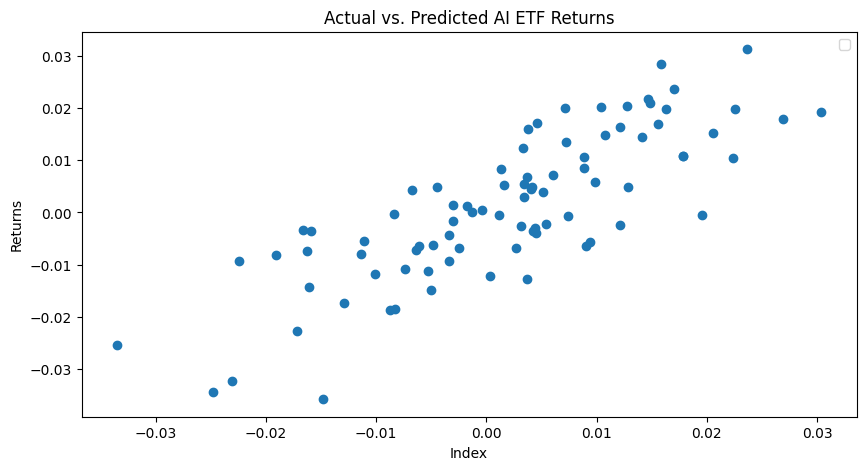

In [ ]:
from sklearn.metrics import mean_squared_error

model = XGBRegressor(n_estimators=1000, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print('')

y_pred_vol = y_pred.std()
y_real_vol = y_test['ARTY'].std()

print(f"Predicted Volatility: {y_pred_vol:.4f}")
print(f"Real Volatility: {y_real_vol:.4f}")

plt.figure(figsize=(10, 5))
#plt.plot(y_test.values, label="Actual Returns", color='blue', alpha=0.6)
#plt.plot(y_pred, label="Predicted Returns", color='red', linestyle="dashed", alpha=0.8)
plt.scatter(y_pred, y_test)
plt.xlabel("Index")
plt.ylabel("Returns")
plt.title("Actual vs. Predicted AI ETF Returns")
plt.legend()
plt.show()

In [ ]:
df_y = pd.DataFrame({
    "Actual Returns": y_test['ARTY'],
    "Predicted Returns": y_pred
}).sort_index()# reorder data after the split
plt.figure(figsize=(12, 5))
plt.plot(df_y['Actual V'], label="Actual Returns", color='green', alpha=0.6)
plt.plot(df_y['Predicted Returns'], label="Pred Returns", color='purple', alpha=0.6)
plt.legend()
plt.show()

KeyError: 'Actual V'

<Figure size 1200x500 with 0 Axes>

In [ ]:
sns.regplot(x = y_test, y = y_pred, line_kws={"color": "red"})
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs. Predicted AI ETF Returns")
plt.show()

print(sm.OLS(y_test, y_pred).fit().summary())

Taking back the start date to 2020 and creating a new col for isGlobalEvent = 0/1. This includes covid, tech market crash post Trump.